# With the new control and armflapping videos (shorter directories), let's see whether we can get a higher accuracy. 

In [2]:
import cv2, os 
import numpy as np 

In [3]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[i * (hand + 1)] = landmark.x
                Y_locations[i * (hand + 1)] = landmark.y
                Z_locations[i * (hand + 1)] = landmark.z
    locations = np.concatenate([X_locations, Y_locations, Z_locations])
    hands.close()
    return locations 

In [4]:
# time to actually do calibration. 

SECONDS_TO_DETECT = 2 # in seconds
DISTANCE_BETWEEN_INPUTS = 0.01 # in seconds, only matters if sampling is True
sampling = False 

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/shorter_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/shorter_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/shorter_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

control_videos: 100%|██████████| 63/63 [00:02<00:00, 22.06it/s]


(105, 51)

In [5]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 51/51 [01:44<00:00,  2.04s/it]


In [6]:
print([len(video) for video in ARMFLAPPING_LOCATIONS])
print([len(video) for video in CONTROL_LOCATIONS])

[121, 61, 121, 90, 90, 90, 72, 72, 90, 90, 49, 49, 90, 90, 90, 72, 72, 72, 90, 121, 49, 97, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 121, 90, 90, 90, 90, 91, 90, 120, 90, 90, 121, 91, 90, 90, 90, 90, 45, 45, 121, 90, 90, 45, 90, 72, 60, 90, 90, 91, 91, 49, 91, 121, 90, 90, 72, 90, 72, 72, 49, 49, 90, 45, 72, 72, 120, 121, 90, 90, 49, 73, 72, 90, 90, 49, 72, 72, 45, 72, 91, 90, 90, 97, 49, 121, 49, 45, 72, 73, 60, 72, 90, 72]
[121, 121, 90, 90, 72, 72, 90, 91, 49, 49, 49, 61, 45, 72, 72, 72, 73, 90, 60, 121, 90, 49, 90, 90, 73, 90, 73, 49, 121, 90, 90, 90, 60, 90, 121, 90, 41, 121, 45, 60, 121, 90, 90, 90, 121, 90, 61, 46, 45, 45, 121]


In [7]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

<ipython-input-7-5fa9d6bc74c5>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
<ipython-input-7-5fa9d6bc74c5>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)
51it [00:00, 11905.03it/s]
51it [00:00, 6678.83it/s](51, 90, 126) (51, 90, 126)



In [8]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [9]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array(test_frames)
    test_frames = pad(test_frames, maxlen = 90)[0]
    
    return model.predict(np.array([test_frames]))

In [17]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 

# Below we'll try various tensorflow random states on various different models. 

using seed 0
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 751ms/step - loss: 0.6772 - accuracy: 0.6173 - val_loss: 0.8227 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 298ms/step - loss: 0.6354 - accuracy: 0.6296 - val_loss: 0.9430 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 1s 305ms/step - loss: 0.5932 - accuracy: 0.6667 - val_loss: 1.0107 - val_accuracy: 0.1905
Epoch 4/30
3/3 [==============================] - 1s 291ms/step - loss: 0.5482 - accuracy: 0.6790 - val_loss: 1.1713 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 311ms/step - loss: 0.5491 - accuracy: 0.7037 - val_loss: 1.1244 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5054 - accuracy: 0.6914 - val_loss: 1.2542 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 331ms/step - loss: 0.5059 - accuracy: 0.7160 - val_loss: 1.2674 - val_acc

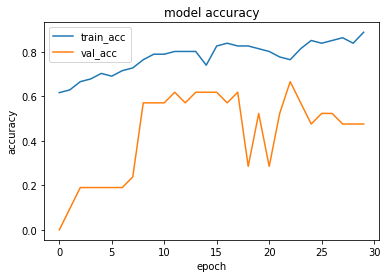

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 481ms/step - loss: 0.6733 - accuracy: 0.6296 - val_loss: 0.8749 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 287ms/step - loss: 0.6331 - accuracy: 0.6296 - val_loss: 1.0402 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 281ms/step - loss: 0.5857 - accuracy: 0.6667 - val_loss: 0.9447 - val_accuracy: 0.1905
Epoch 4/30
3/3 [==============================] - 1s 289ms/step - loss: 0.5407 - accuracy: 0.6914 - val_loss: 1.2010 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 282ms/step - loss: 0.5423 - accuracy: 0.6914 - val_loss: 1.2414 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 299ms/step - loss: 0.4992 - accuracy: 0.7284 - val_loss: 1.3976 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 278ms/step - loss: 0.4998 - accuracy: 0.7407 - val_loss: 1.3428 - val_accuracy: 0.

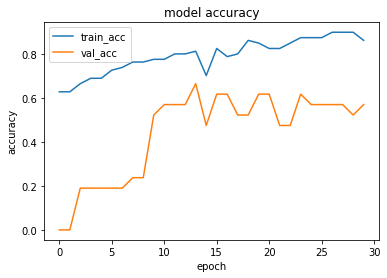

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 451ms/step - loss: 0.6604 - accuracy: 0.6296 - val_loss: 0.8790 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 471ms/step - loss: 0.6980 - accuracy: 0.6296 - val_loss: 0.9022 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 445ms/step - loss: 0.6501 - accuracy: 0.6296 - val_loss: 0.8263 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 487ms/step - loss: 0.6424 - accuracy: 0.6543 - val_loss: 0.8827 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 453ms/step - loss: 0.6209 - accuracy: 0.6420 - val_loss: 1.0605 - val_accuracy: 0.0000e+00
Epoch 6/30
3/3 [==============================] - 2s 720ms/step - loss: 0.5689 - accuracy: 0.7284 - val_loss: 1.0490 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 442ms/step - loss: 0.5586 - accuracy: 0.6790 - val_loss: 1.0615 - val_accuracy

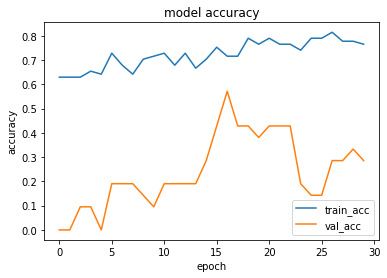

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 419ms/step - loss: 0.6570 - accuracy: 0.6790 - val_loss: 0.9295 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 439ms/step - loss: 0.6268 - accuracy: 0.6543 - val_loss: 0.9687 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 712ms/step - loss: 0.6546 - accuracy: 0.6790 - val_loss: 0.8392 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 403ms/step - loss: 0.6401 - accuracy: 0.6914 - val_loss: 0.8342 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 433ms/step - loss: 0.6124 - accuracy: 0.6296 - val_loss: 0.9092 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 1s 421ms/step - loss: 0.5801 - accuracy: 0.6790 - val_loss: 0.9653 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 443ms/step - loss: 0.5938 - accuracy: 0.6667 - val_loss: 1.0086 - val_accuracy: 0.

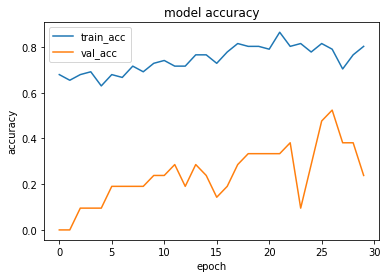

using seed 1
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 499ms/step - loss: 0.6820 - accuracy: 0.6173 - val_loss: 0.8505 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 305ms/step - loss: 0.6484 - accuracy: 0.6296 - val_loss: 0.9036 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 292ms/step - loss: 0.6171 - accuracy: 0.6296 - val_loss: 0.8946 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 283ms/step - loss: 0.5843 - accuracy: 0.6420 - val_loss: 1.1030 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 277ms/step - loss: 0.5947 - accuracy: 0.6667 - val_loss: 1.1729 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 279ms/step - loss: 0.5477 - accuracy: 0.7037 - val_loss: 0.9271 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 288ms/step - loss: 0.5263 - accuracy: 0.7160 - val_loss: 1.0351 - val

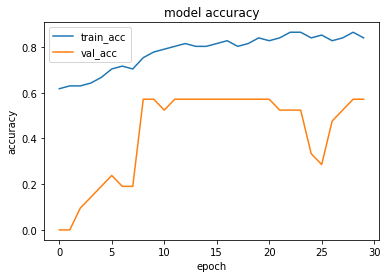

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 507ms/step - loss: 0.6885 - accuracy: 0.5185 - val_loss: 0.9263 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 290ms/step - loss: 0.6465 - accuracy: 0.6296 - val_loss: 0.8834 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6282 - accuracy: 0.6296 - val_loss: 0.8270 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 296ms/step - loss: 0.6080 - accuracy: 0.6543 - val_loss: 0.9270 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 341ms/step - loss: 0.5845 - accuracy: 0.6543 - val_loss: 1.1273 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 1s 300ms/step - loss: 0.5603 - accuracy: 0.6667 - val_loss: 1.0223 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5270 - accuracy: 0.6914 - val_loss: 1.0202 - val_accuracy: 0.

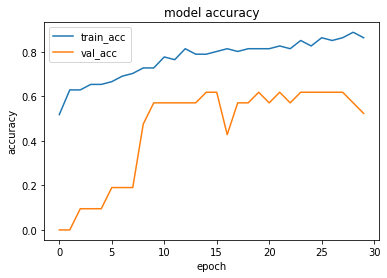

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6915 - accuracy: 0.6420 - val_loss: 0.8376 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 421ms/step - loss: 0.6534 - accuracy: 0.6296 - val_loss: 0.7893 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 404ms/step - loss: 0.6384 - accuracy: 0.6790 - val_loss: 0.7671 - val_accuracy: 0.1429
Epoch 4/30
3/3 [==============================] - 1s 440ms/step - loss: 0.6162 - accuracy: 0.6914 - val_loss: 0.8345 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 409ms/step - loss: 0.6462 - accuracy: 0.6420 - val_loss: 0.9279 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 2s 691ms/step - loss: 0.5894 - accuracy: 0.6543 - val_loss: 0.9580 - val_accuracy: 0.1429
Epoch 7/30
3/3 [==============================] - 1s 434ms/step - loss: 0.5594 - accuracy: 0.7407 - val_loss: 1.0324 - val_accuracy: 0.

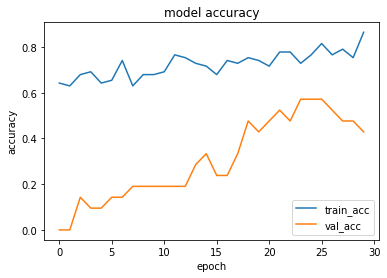

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 430ms/step - loss: 0.7133 - accuracy: 0.4568 - val_loss: 0.8094 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 430ms/step - loss: 0.6449 - accuracy: 0.6296 - val_loss: 0.8296 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 706ms/step - loss: 0.6382 - accuracy: 0.6296 - val_loss: 0.8266 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 435ms/step - loss: 0.6024 - accuracy: 0.6543 - val_loss: 0.8606 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 423ms/step - loss: 0.6100 - accuracy: 0.6914 - val_loss: 0.9676 - val_accuracy: 0.1429
Epoch 6/30
3/3 [==============================] - 1s 410ms/step - loss: 0.5967 - accuracy: 0.6543 - val_loss: 0.9587 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 417ms/step - loss: 0.5715 - accuracy: 0.6790 - val_loss: 1.0458 - val_accuracy

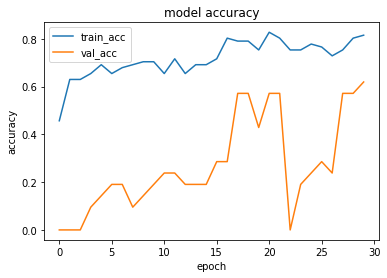

using seed 13
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 496ms/step - loss: 0.6823 - accuracy: 0.6543 - val_loss: 0.8520 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 304ms/step - loss: 0.6392 - accuracy: 0.6296 - val_loss: 1.0386 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 297ms/step - loss: 0.6026 - accuracy: 0.6296 - val_loss: 0.9933 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 283ms/step - loss: 0.5677 - accuracy: 0.6790 - val_loss: 0.9833 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 280ms/step - loss: 0.5295 - accuracy: 0.7160 - val_loss: 1.3741 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 305ms/step - loss: 0.5715 - accuracy: 0.6914 - val_loss: 1.2029 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 283ms/step - loss: 0.4836 - accuracy: 0.7284 - val_loss: 1.1023 - va

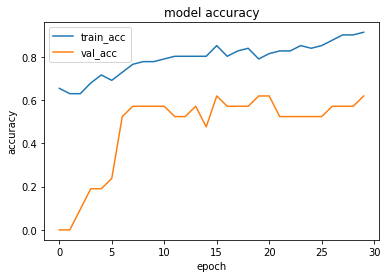

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 505ms/step - loss: 0.6697 - accuracy: 0.6790 - val_loss: 0.9281 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 303ms/step - loss: 0.6196 - accuracy: 0.6296 - val_loss: 1.0279 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 1s 320ms/step - loss: 0.5614 - accuracy: 0.6790 - val_loss: 1.0858 - val_accuracy: 0.1905
Epoch 4/30
3/3 [==============================] - 1s 313ms/step - loss: 0.5441 - accuracy: 0.6914 - val_loss: 1.2645 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 324ms/step - loss: 0.5623 - accuracy: 0.7160 - val_loss: 1.0152 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 317ms/step - loss: 0.5050 - accuracy: 0.7284 - val_loss: 1.2765 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 310ms/step - loss: 0.5055 - accuracy: 0.6914 - val_loss: 1.4345 - val_accuracy: 0.0952

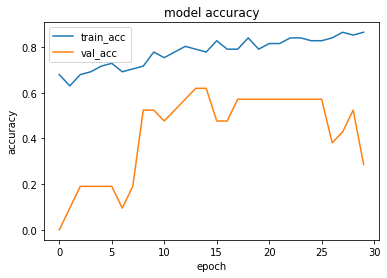

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 466ms/step - loss: 0.6616 - accuracy: 0.6173 - val_loss: 0.8636 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 470ms/step - loss: 0.6647 - accuracy: 0.6296 - val_loss: 0.8119 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 473ms/step - loss: 0.6362 - accuracy: 0.6420 - val_loss: 0.7732 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 473ms/step - loss: 0.6274 - accuracy: 0.6543 - val_loss: 0.8408 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 449ms/step - loss: 0.6079 - accuracy: 0.6420 - val_loss: 0.9987 - val_accuracy: 0.0952
Epoch 6/30
3/3 [==============================] - 2s 684ms/step - loss: 0.6017 - accuracy: 0.6790 - val_loss: 0.9855 - val_accuracy: 0.1429
Epoch 7/30
3/3 [==============================] - 1s 414ms/step - loss: 0.5646 - accuracy: 0.7160 - val_loss: 1.0091 - val_accuracy: 0.

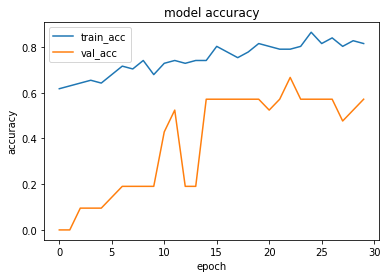

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 485ms/step - loss: 0.6755 - accuracy: 0.5556 - val_loss: 0.8694 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 463ms/step - loss: 0.6398 - accuracy: 0.6296 - val_loss: 0.8399 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 733ms/step - loss: 0.6350 - accuracy: 0.6296 - val_loss: 0.8148 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 466ms/step - loss: 0.6127 - accuracy: 0.6543 - val_loss: 0.8224 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 466ms/step - loss: 0.6244 - accuracy: 0.6543 - val_loss: 0.8839 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 464ms/step - loss: 0.5854 - accuracy: 0.6914 - val_loss: 0.7622 - val_accuracy: 0.5714
Epoch 7/30
3/3 [==============================] - 1s 439ms/step - loss: 0.5945 - accuracy: 0.6914 - val_loss: 0.8627 - val_accuracy: 0.

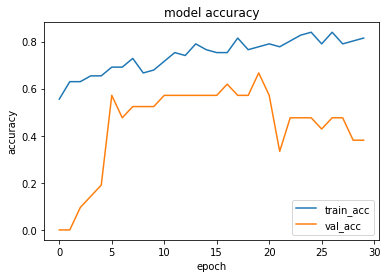

using seed 42
On the 0th model
Epoch 1/30
3/3 [==============================] - 1s 425ms/step - loss: 0.6843 - accuracy: 0.5185 - val_loss: 0.8560 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 279ms/step - loss: 0.6354 - accuracy: 0.6296 - val_loss: 0.9981 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 282ms/step - loss: 0.6130 - accuracy: 0.6296 - val_loss: 1.0424 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 279ms/step - loss: 0.5547 - accuracy: 0.6914 - val_loss: 0.9121 - val_accuracy: 0.2381
Epoch 5/30
3/3 [==============================] - 1s 291ms/step - loss: 0.5512 - accuracy: 0.7160 - val_loss: 1.1745 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 301ms/step - loss: 0.5244 - accuracy: 0.7160 - val_loss: 1.0589 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 310ms/step - loss: 0.5008 - accuracy: 0.7284 - val_loss: 1.1445 - va

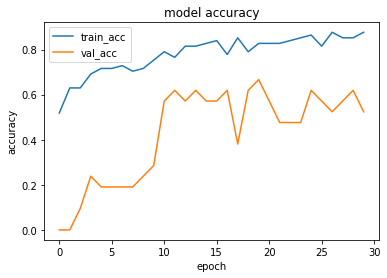

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 478ms/step - loss: 0.6738 - accuracy: 0.5802 - val_loss: 0.9678 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 325ms/step - loss: 0.6252 - accuracy: 0.6296 - val_loss: 1.0082 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 351ms/step - loss: 0.5956 - accuracy: 0.6296 - val_loss: 1.0416 - val_accuracy: 0.1429
Epoch 4/30
3/3 [==============================] - 1s 302ms/step - loss: 0.5568 - accuracy: 0.6790 - val_loss: 0.9826 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 340ms/step - loss: 0.5458 - accuracy: 0.7037 - val_loss: 1.1481 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 312ms/step - loss: 0.5372 - accuracy: 0.7160 - val_loss: 0.9521 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 333ms/step - loss: 0.5041 - accuracy: 0.7160 - val_loss: 1.0438 - val_accuracy: 0.

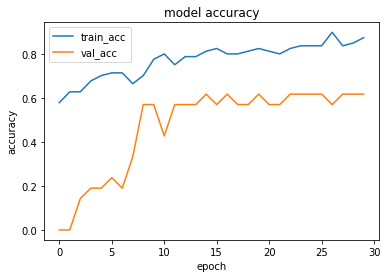

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 423ms/step - loss: 0.6499 - accuracy: 0.6296 - val_loss: 0.8778 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 471ms/step - loss: 0.6095 - accuracy: 0.6296 - val_loss: 0.7476 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 1s 429ms/step - loss: 0.7053 - accuracy: 0.6420 - val_loss: 0.7424 - val_accuracy: 0.1429
Epoch 4/30
3/3 [==============================] - 1s 478ms/step - loss: 0.6407 - accuracy: 0.6667 - val_loss: 0.7406 - val_accuracy: 0.6190
Epoch 5/30
3/3 [==============================] - 1s 435ms/step - loss: 0.6395 - accuracy: 0.6667 - val_loss: 0.8266 - val_accuracy: 0.1429
Epoch 6/30
3/3 [==============================] - 2s 690ms/step - loss: 0.6112 - accuracy: 0.7037 - val_loss: 0.9863 - val_accuracy: 0.0952
Epoch 7/30
3/3 [==============================] - 1s 428ms/step - loss: 0.6053 - accuracy: 0.6049 - val_loss: 1.0274 - val_accuracy: 0.1429

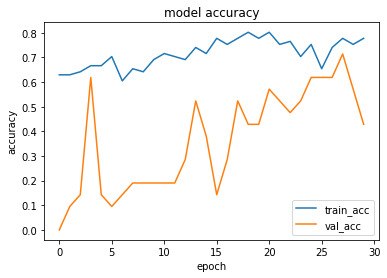

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 478ms/step - loss: 0.6759 - accuracy: 0.5802 - val_loss: 0.8376 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 444ms/step - loss: 0.6360 - accuracy: 0.6296 - val_loss: 0.8153 - val_accuracy: 0.0952
Epoch 3/30
3/3 [==============================] - 2s 715ms/step - loss: 0.6268 - accuracy: 0.6296 - val_loss: 0.9331 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 476ms/step - loss: 0.6036 - accuracy: 0.6296 - val_loss: 0.9737 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 408ms/step - loss: 0.5778 - accuracy: 0.6914 - val_loss: 1.0193 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 496ms/step - loss: 0.5481 - accuracy: 0.7037 - val_loss: 1.0169 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 483ms/step - loss: 0.5136 - accuracy: 0.6914 - val_loss: 1.2170 - val_accuracy: 0.

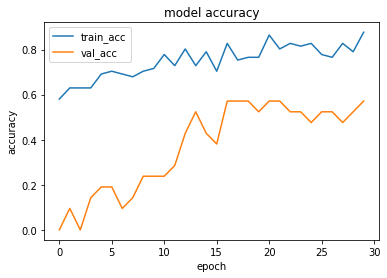

using seed 69
On the 0th model
Epoch 1/30
3/3 [==============================] - 1s 444ms/step - loss: 0.6769 - accuracy: 0.6296 - val_loss: 0.9049 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 291ms/step - loss: 0.6365 - accuracy: 0.6296 - val_loss: 0.9838 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 323ms/step - loss: 0.5990 - accuracy: 0.6420 - val_loss: 1.0729 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 297ms/step - loss: 0.5554 - accuracy: 0.6790 - val_loss: 1.1111 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 332ms/step - loss: 0.5490 - accuracy: 0.6914 - val_loss: 1.3293 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5449 - accuracy: 0.6914 - val_loss: 1.3743 - val_accuracy: 0.2381
Epoch 7/30
3/3 [==============================] - 1s 299ms/step - loss: 0.4964 - accuracy: 0.7160 - val_loss: 1.0174 - va

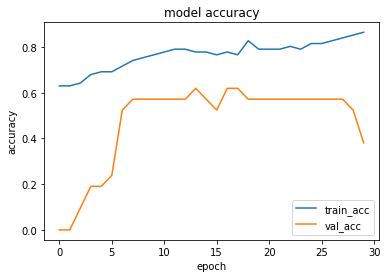

On the 1th model
Epoch 1/30
3/3 [==============================] - 1s 456ms/step - loss: 0.6993 - accuracy: 0.4691 - val_loss: 0.9007 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 312ms/step - loss: 0.6392 - accuracy: 0.6296 - val_loss: 1.0398 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 294ms/step - loss: 0.6032 - accuracy: 0.6296 - val_loss: 1.0229 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 296ms/step - loss: 0.5665 - accuracy: 0.6790 - val_loss: 0.9917 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5421 - accuracy: 0.7037 - val_loss: 1.2117 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 295ms/step - loss: 0.5598 - accuracy: 0.6790 - val_loss: 1.3388 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 300ms/step - loss: 0.5337 - accuracy: 0.6914 - val_loss: 1.0339 - val_accuracy: 0.

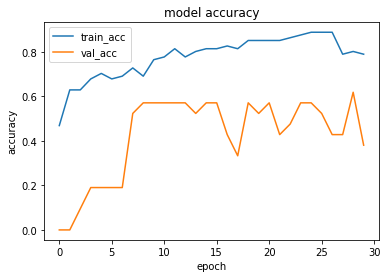

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 447ms/step - loss: 0.6871 - accuracy: 0.6049 - val_loss: 0.7968 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 483ms/step - loss: 0.6467 - accuracy: 0.6296 - val_loss: 0.7652 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 474ms/step - loss: 0.6662 - accuracy: 0.6296 - val_loss: 0.7856 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 451ms/step - loss: 0.6413 - accuracy: 0.6296 - val_loss: 0.8197 - val_accuracy: 0.0000e+00
Epoch 5/30
3/3 [==============================] - 1s 413ms/step - loss: 0.6420 - accuracy: 0.6296 - val_loss: 0.8681 - val_accuracy: 0.0000e+00
Epoch 6/30
3/3 [==============================] - 2s 664ms/step - loss: 0.6198 - accuracy: 0.6543 - val_loss: 0.9565 - val_accuracy: 0.0952
Epoch 7/30
3/3 [==============================] - 1s 454ms/step - loss: 0.5881 - accuracy: 0.6543 - val_loss: 0.8993 - val_

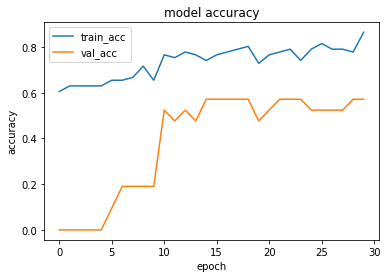

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 443ms/step - loss: 0.6821 - accuracy: 0.6420 - val_loss: 0.8624 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 440ms/step - loss: 0.6399 - accuracy: 0.6420 - val_loss: 0.8499 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 712ms/step - loss: 0.6136 - accuracy: 0.6790 - val_loss: 0.9132 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 450ms/step - loss: 0.6193 - accuracy: 0.6420 - val_loss: 1.1235 - val_accuracy: 0.0952
Epoch 5/30
3/3 [==============================] - 1s 447ms/step - loss: 0.5686 - accuracy: 0.6543 - val_loss: 1.1538 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 454ms/step - loss: 0.5391 - accuracy: 0.7160 - val_loss: 1.2369 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 434ms/step - loss: 0.5488 - accuracy: 0.7037 - val_loss: 1.1083 - val_accuracy: 0.

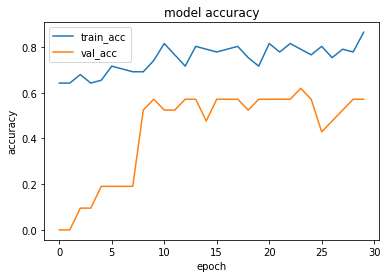

using seed 100
On the 0th model
Epoch 1/30
3/3 [==============================] - 2s 474ms/step - loss: 0.6647 - accuracy: 0.6296 - val_loss: 0.8776 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 327ms/step - loss: 0.6084 - accuracy: 0.6296 - val_loss: 0.9753 - val_accuracy: 0.1429
Epoch 3/30
3/3 [==============================] - 1s 326ms/step - loss: 0.5460 - accuracy: 0.7037 - val_loss: 0.7559 - val_accuracy: 0.2857
Epoch 4/30
3/3 [==============================] - 1s 312ms/step - loss: 0.5796 - accuracy: 0.7284 - val_loss: 1.2680 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 297ms/step - loss: 0.5151 - accuracy: 0.6914 - val_loss: 1.0911 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 285ms/step - loss: 0.4941 - accuracy: 0.7037 - val_loss: 1.0195 - val_accuracy: 0.2857
Epoch 7/30
3/3 [==============================] - 1s 301ms/step - loss: 0.4848 - accuracy: 0.7407 - val_loss: 1.1330 - val_a

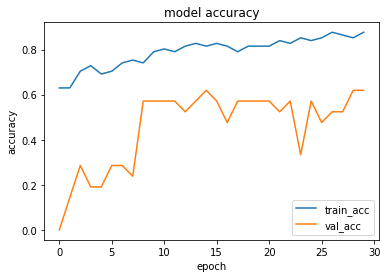

On the 1th model
Epoch 1/30
3/3 [==============================] - 2s 476ms/step - loss: 0.6759 - accuracy: 0.6420 - val_loss: 0.8707 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 319ms/step - loss: 0.6321 - accuracy: 0.6296 - val_loss: 1.1076 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 297ms/step - loss: 0.6121 - accuracy: 0.6296 - val_loss: 1.0460 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 301ms/step - loss: 0.5519 - accuracy: 0.7037 - val_loss: 0.7869 - val_accuracy: 0.2381
Epoch 5/30
3/3 [==============================] - 1s 284ms/step - loss: 0.5622 - accuracy: 0.6790 - val_loss: 1.1180 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 289ms/step - loss: 0.5302 - accuracy: 0.7037 - val_loss: 1.1946 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 288ms/step - loss: 0.5104 - accuracy: 0.7037 - val_loss: 0.9729 - val_accuracy: 0.

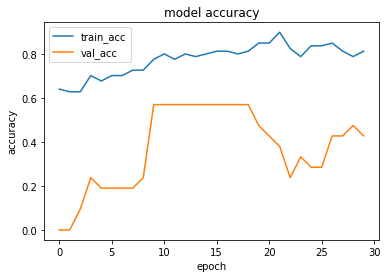

On the 2th model
Epoch 1/30
3/3 [==============================] - 1s 453ms/step - loss: 0.6659 - accuracy: 0.5432 - val_loss: 0.8915 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 424ms/step - loss: 0.6590 - accuracy: 0.6296 - val_loss: 0.9042 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6599 - accuracy: 0.6296 - val_loss: 0.8194 - val_accuracy: 0.0952
Epoch 4/30
3/3 [==============================] - 1s 423ms/step - loss: 0.6134 - accuracy: 0.7037 - val_loss: 0.7733 - val_accuracy: 0.1905
Epoch 5/30
3/3 [==============================] - 1s 415ms/step - loss: 0.6009 - accuracy: 0.6914 - val_loss: 0.8817 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 2s 682ms/step - loss: 0.5920 - accuracy: 0.6543 - val_loss: 0.8805 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 414ms/step - loss: 0.5641 - accuracy: 0.6543 - val_loss: 0.7614 - val_accuracy: 0.

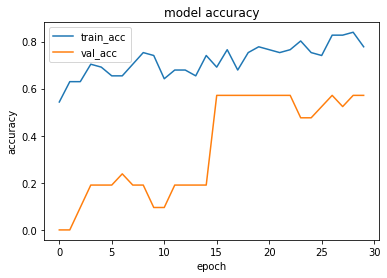

On the 3th model
Epoch 1/30
3/3 [==============================] - 1s 425ms/step - loss: 0.6608 - accuracy: 0.5556 - val_loss: 0.8623 - val_accuracy: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 1s 448ms/step - loss: 0.6740 - accuracy: 0.6296 - val_loss: 0.9552 - val_accuracy: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 2s 733ms/step - loss: 0.6311 - accuracy: 0.6420 - val_loss: 0.9260 - val_accuracy: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 1s 418ms/step - loss: 0.6012 - accuracy: 0.6914 - val_loss: 0.9010 - val_accuracy: 0.1429
Epoch 5/30
3/3 [==============================] - 1s 407ms/step - loss: 0.5794 - accuracy: 0.6914 - val_loss: 1.0638 - val_accuracy: 0.1905
Epoch 6/30
3/3 [==============================] - 1s 417ms/step - loss: 0.5980 - accuracy: 0.6790 - val_loss: 1.0540 - val_accuracy: 0.1905
Epoch 7/30
3/3 [==============================] - 1s 432ms/step - loss: 0.5847 - accuracy: 0.6790 - val_loss: 0.8951 - val_accuracy

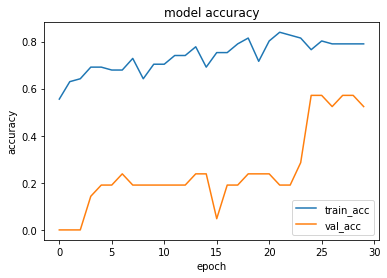

In [19]:
import tensorflow as tf 
for tf_random_seed in [0, 1, 13, 42, 69, 100]: 
    tf.random.set_seed(tf_random_seed)
    print(f"using seed {tf_random_seed}")

    base_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.LSTM(128, return_sequences=False), 
        tf.keras.layers.Dense(128, activation="relu"), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    dropout_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.LSTM(128, return_sequences = False),  
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1, activation = "sigmoid")    
    ])

    aug_model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.LSTM(128, return_sequences = False),  
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    pure_aug_model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences = True), 
        tf.keras.layers.LSTM(128, return_sequences = False),  
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    for i, model in enumerate([base_model, dropout_model, aug_model, pure_aug_model]): 
        print(f"On the {i}th model")
        model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy']) 
    
        history = model.fit(X, y, validation_split = 0.2, epochs = 30)

        num = None if i == 0 else i 
        plot(history, num = num) 